<a href="https://colab.research.google.com/github/towardsai/tutorials/blob/master/sentiment_analysis_tutorial/sentiment_analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Women's Dress Review

* Tutorial: https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c

* Github: https://github.com/towardsai/tutorials/tree/master/sentyment_analysis_tutorial

**Download Dataset**

In [3]:
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv

--2020-12-09 22:10:49--  https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8480236 (8.1M) [text/plain]
Saving to: ‘women_clothing_review.csv’

women_clothing_revi 100%[===================>]   8.09M  25.7MB/s    in 0.3s    

2020-12-09 22:10:50 (25.7 MB/s) - ‘women_clothing_review.csv’ saved [8480236/8480236]



**Import All Required Packages**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Read data from csv**

In [8]:
df = pd.read_csv('women_clothing_review.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**Drop unnecessary columns**

In [9]:
df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0', ], axis=1)
df.dropna(inplace=True)

**Calculation of Polarity**

In [10]:
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [11]:
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive


**Plot the Rating visualization graph**

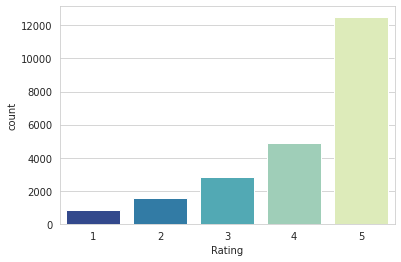

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

**Plot the Polarity Rating count**

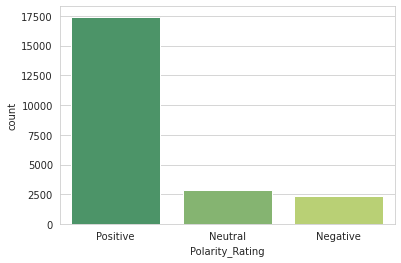

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

**Data Preprocessing**

In [14]:
df_Positive = df[df['Polarity_Rating'] == 'Positive'][0:8000]
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

**Sample negative and neutral polarity dataset and create final dataframe**

In [15]:
df_Neutral_over = df_Neutral.sample(8000, replace=True)
df_Negative_over = df_Negative.sample(8000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

**Text Preprocessing**

In [16]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

**Apply the method "get_text_processing" into column review text**

In [17]:
df['review'] = df['Review Text'].apply(get_text_processing)
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating,review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...
6,858,39,I aded this in my basket at hte last mintue to...,5,1,General Petite,Tops,Knits,Positive,aded basket hte last mintue see would look lik...


**Visualize Text Review with Polarity Rating**

In [18]:
df = df[['review', 'Polarity_Rating']]
df.head()

,review,Polarity_Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive
6,aded basket hte last mintue see would look lik...,Positive


**Apply One hot encoding on negative, neutral, and positive**

In [19]:
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,review,Negative,Neutral,Positive
0,Absolutely wonderful silky sexy comfortable,0,0,1
1,Love dress sooo pretty happened find store im ...,0,0,1
3,love love love jumpsuit fun flirty fabulous ev...,0,0,1
4,shirt flattering due adjustable front tie perf...,0,0,1
6,aded basket hte last mintue see would look lik...,0,0,1


**Apply Train Test Split**

In [20]:
X = df['review'].values
y = df.drop('review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

**Apply vectorization**

In [21]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Apply frequency, inverse document frequency:**

In [22]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

**Add different layers**

In [23]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

**Fit the Model**

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
58/66 [=========================>....] - ETA: 41s - loss: 0.6450 - accuracy: 0.7124

**Evaluation of Model**

In [ ]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

**Prediction**

In [ ]:
preds = model.predict(X_test)
preds